<a href="https://colab.research.google.com/github/k-k-k-i-i/k-k-k-i-i.github.io/blob/main/predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## データの可視化




#### 判明していること
$$w \sim \mathcal{N}(1, 0) \text{ : white noise}$$
$$r_{1,n} = \sum_{k=1}^n{w_{1,k}},
\space\space\space\space r_{2,n} = \sum_{k=1}^n{w_{2,k}}
 \text{ : random walk}$$
$$r ̃ _{1,n} = \frac{r_{1,n}-\mu_{r_1}}{\sigma_{r_1}}$$
$$T_a = 300+2r ̃ _{1,n} \space \text{ : air temperature [K]}$$
$$T_p = 10+T_a +r_{2,n}= 310 +2r ̃ _{1,n}+r_{2,n} \space \text{ : process temperature [K]}$$


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('./data/predictive_maintenance.csv')
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [54]:
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


## 学習～評価

### プロンプト

以下の条件を満たす機械学習のコードをpythonで記述してください。

< 条件 >
・csvデータをpandasで読み込む。
・教師あり学習の二値分類問題を解く。
・ラベルデータはcsvに含まれている。
・評価指標はROCAUCとする。
・機械学習モデルはlightGBMを用いる。
・ハイパーパラメータのチューニングにはoptunaを用いる。
・モデル性能の評価にはstratifiedな交差検証を用い、この検証結果がハイパーパラメータのチューニングに反映されるものとする。
・チューニングされたモデルによりテストデータにおける予測を行い、予測結果のROC曲線をmatplotlibを用いて描画する。（横軸及び縦軸のラベルとグリッド線を表示する）
・Google Colab環境で動作する（例えばoptunaなどはインストールされていないため、!pip install optunaなどと冒頭で記述することが必要）

以下のコードにおいてroc_curveという関数を正しく定義してください。

< コード >
（コードを貼り付ける）

### ライブラリのインストール

In [55]:
#!pip install pandas lightgbm optuna scikit-learn matplotlib

### 準備（ライブラリのインポート, データの読み込みなど）

In [56]:
import time
import pandas as pd
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

# データの読み込み
data = pd.read_csv('./data/predictive_maintenance.csv')
"""
# サンプルデータを生成する場合は以下
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
"""
data # 表示

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


### データの前処理

In [57]:
# 前処理用のクラスの読み込み
label_encoder = LabelEncoder()
scaler = StandardScaler()

# x: リネーム
feature_names_old = ['Air temperature [K]', 'Process temperature [K]',
                     'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
feature_names_new = ['Ta', 'Tp', 'rpm', 'torque', 'w']
dict_rename = dict(map(lambda x, y: (x, y), feature_names_old, feature_names_new))
data.rename(columns=dict_rename, inplace=True)

# カテゴリ変数をエンコード
data['Target'] = label_encoder.fit_transform(data['Target'])
data['Type']   = label_encoder.fit_transform(data['Type'])

# x: 特徴量エンジニアリング（dfのまま）
data['dT'] = data.loc[:,'Tp'] - data.loc[:,'Ta']
feature_names = ['Type', 'dT', 'rpm', 'torque', 'w'] # 必要な分だけ取り出す
data_X = data[feature_names].copy()

# x: スケーリング
feature_names_scaled = feature_names[1:]
data_X[feature_names_scaled] = scaler.fit_transform(data_X[feature_names_scaled])

# ndarray型に変換
X = data_X.values
y = data['Target'].values

# データを学習用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

data_X # 表示

,Type,dT,rpm,torque,w
0,2,0.498849,0.068185,0.282200,-1.695984
1,1,0.498849,-0.729472,0.633308,-1.648852
2,1,0.398954,-0.227450,0.944290,-1.617430
3,1,0.398954,-0.590021,-0.048845,-1.586009
4,1,0.498849,-0.729472,0.001313,-1.554588
...,...,...,...,...,...
9995,2,-0.400212,0.363820,-1.052012,-1.476034
9996,0,-0.500108,0.520005,-0.821283,-1.428902
9997,2,-0.400212,0.592519,-0.660777,-1.350349
9998,0,-0.300317,-0.729472,0.854005,-1.303217


### 目的関数の定義（for Optuna）

In [58]:
def objective(trial):
    params = {
        'objective': 'binary',  # 二値分類
        'metric': 'roc_auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': -1
    }

    # 交差検証（StratifiedKFold）
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_valid_fold, y_valid_fold = X_train[valid_idx], y_train[valid_idx]
        dtrain = lgb.Dataset(X_train_fold, label=y_train_fold, feature_name=feature_names)
        dvalid = lgb.Dataset(X_valid_fold, label=y_valid_fold, feature_name=feature_names)

        model = lgb.train(params,
                          dtrain,
                          valid_sets=[dvalid],
                          )

        y_pred = model.predict(X_valid_fold)
        auc = roc_auc_score(y_valid_fold, y_pred)
        aucs.append(auc)

    return 1 - sum(aucs) / len(aucs)  # 最小化するため1からAUCを引く

### early stopping callback

In [59]:
def early_stopping_callback(study, trial):
    n_recent_trials = 200 # 直近の試行回数
    history = [trial.value for trial in study.trials[:-n_recent_trials-1:-1]] # 直近の評価値を取得
    min_val = min([trial.value for trial in study.trials]) # 今までの評価値の最小値を取得

    # 一定期間改善がない場合に早期終了
    if len(history) >= n_recent_trials and all(history[i] > min_val for i in range(n_recent_trials - 1)):
          study.stop()
          print("[Early stopping] No improvement in the metric for the last {} trials.".format(n_recent_trials))

### モデルの構築

In [60]:
# 特定の警告を無視する
warnings.filterwarnings("ignore", category=FutureWarning)

# Optunaによるハイパーパラメータチューニング
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=600, callbacks=[early_stopping_callback])  # 適当な試行回数を指定

# チューニング後の最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_model  = lgb.train(best_params, lgb.Dataset(X_train, label=y_train, feature_name=feature_names))

[I 2023-12-17 15:04:15,008] A new study created in memory with name: no-name-6155b345-ee89-4cb3-a09d-15dbacebea60
[I 2023-12-17 15:04:15,540] Trial 0 finished with value: 0.021465555211746312 and parameters: {'num_leaves': 16, 'learning_rate': 0.03444433440262224, 'feature_fraction': 0.8937260354355729, 'bagging_fraction': 0.5366289318297057, 'bagging_freq': 5}. Best is trial 0 with value: 0.021465555211746312.
[I 2023-12-17 15:04:16,129] Trial 1 finished with value: 0.022620810735707986 and parameters: {'num_leaves': 8, 'learning_rate': 0.04095005057583652, 'feature_fraction': 0.977464865229481, 'bagging_fraction': 0.47513094944449363, 'bagging_freq': 8}. Best is trial 0 with value: 0.021465555211746312.
[I 2023-12-17 15:04:18,975] Trial 2 finished with value: 0.03140252853203285 and parameters: {'num_leaves': 28, 'learning_rate': 0.0749662372610397, 'feature_fraction': 0.3213092007670557, 'bagging_fraction': 0.46899374498012414, 'bagging_freq': 3}. Best is trial 0 with value: 0.02146

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] Start training from score 0.033875


### モデルの評価

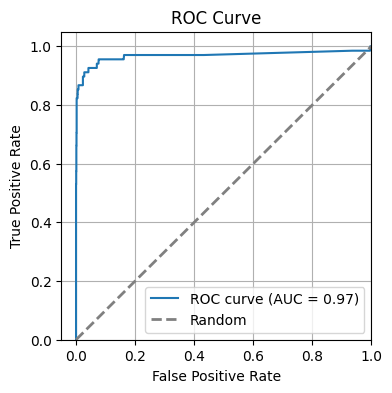

In [61]:
# テストデータにおける予測とROCAUCの計算
y_pred_test = best_model.predict(X_test)
roc_auc     = roc_auc_score(y_test, y_pred_test)

# ROC曲線の描画
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
margin = 0.05
plt.xlim(-margin,1)
plt.ylim(0,1+margin)
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig("ROC Curve.png", dpi=600)

In [62]:
threshold = 0.5  # 閾値の定義

# 閾値に対するtprとfprを求める
y_pred_test_bin = (y_pred_test > threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_test_bin)

# Pandas DataFrameに変換
labels  = ['実際は正常', '実際は故障']
columns = ['正常と予測', '故障と予測']
df_confusion = pd.DataFrame(conf_matrix, index=labels, columns=columns)
df_confusion

,正常と予測,故障と予測
実際は正常,1928,4
実際は故障,16,52


### モデルの解釈

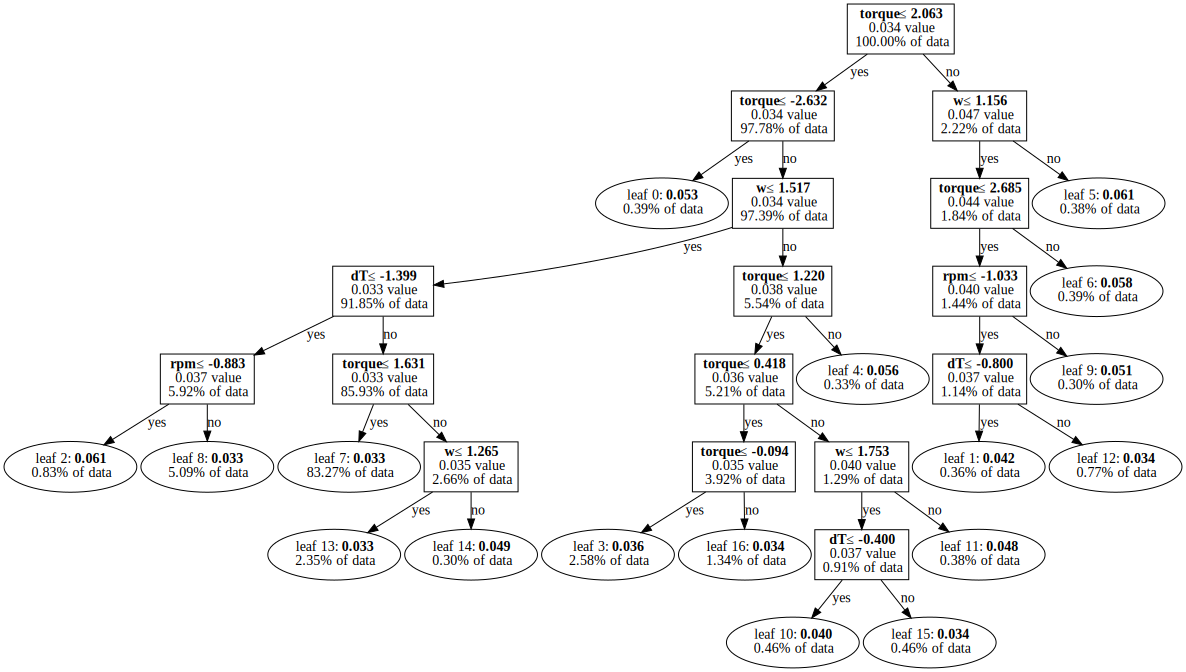

In [63]:
# https://qiita.com/CookieBox26/items/0bab0d3868b853167210
graph = lgb.create_tree_digraph(
    best_model, show_info=['internal_value', 'data_percentage'],
    orientation='vertical',
    #node_attr={'fontname': 'M PLUS 1', 'fontsize': '11'},  # 日本語フォント
    #edge_attr={'fontname': 'M PLUS 1', 'fontsize': '10'},  # 日本語フォント
)
graph.format = 'png'
graph
graph.render(filename='tree', format='png', cleanup=True, dpi=600)

#lgb.plot_tree(best_model, tree_index=0, figsize=(20, 10), show_info=['split_gain'],orientation='vertical')
#plt.show()